# DTSA-5511 Week 3 Programming Assignment

In this assignment, I used the [Histopathologic Cancer Detection](https://www.kaggle.com/competitions/histopathologic-cancer-detection/submissions#) Kaggle competition data to train a convolutional neural network (CNN) to detect tumors in pathology images.

The training set consists of 220,025 .tif image files, which are all 96x96 patches taken from larger pathology images. The test set contains another 57,458 96x96 images. I split the training set 80/20 to create training and validation sets, which have 176,020 and 44,005 images, respectively.

I ran this notebook in a Google Colab environment connected to an Nvidia A100 GPU. Training for 10 epochs (batch size of 256) took approximately 23 minutes. Running inference against the test set took approximately 37 seconds.




## Import Data

In [1]:
from google.colab import files

In [ ]:
files.upload()

In [3]:
!pwd

/content


In [4]:
!mkdir -p /root/.config/kaggle

In [5]:
!mv kaggle.json /root/.config/kaggle/

In [6]:
!chmod 600 /root/.config/kaggle/kaggle.json

In [7]:
!kaggle competitions download -c histopathologic-cancer-detection

 99% 6.24G/6.31G [00:16<00:00, 604MB/s]
100% 6.31G/6.31G [00:16<00:00, 410MB/s]


In [8]:
!unzip -q histopathologic-cancer-detection.zip

## Exploratory Data Analysis

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

from PIL import Image
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model

In [10]:
train_valid_df = pd.read_csv("/content/train_labels.csv")

We'll start by inspecting the training data set structure. Each value in the `id` column corresponds to the name of an image file. The `label` column value indicates the presence (`1`) or absence (`0`) of a tumor.

In [11]:
train_valid_df.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


In [12]:
# View distribution of positive and negative labels
print(train_valid_df['label'].value_counts())

label
0    130908
1     89117
Name: count, dtype: int64


We see the images in the training dataset with label `0` (no tumor detected) outnumber the images with label `1` (tumor detected). We'll have to account for this when we split the train and validation sets to make sure the proportion of `1` and `0` labels in both sets is equivalent to the training set.

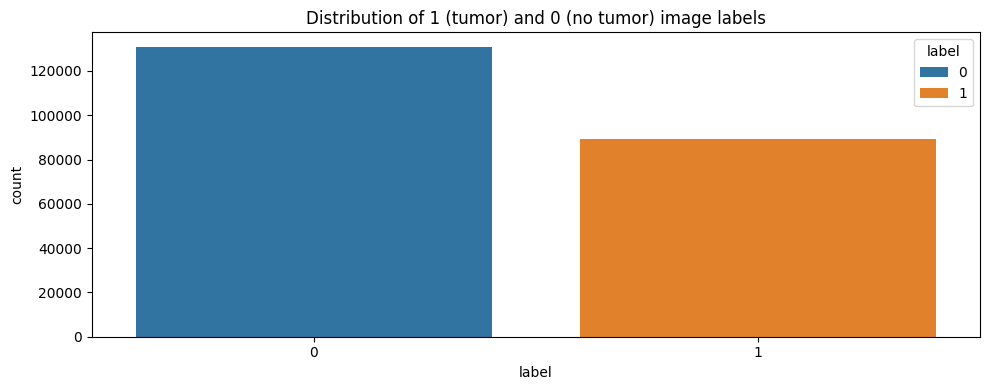

In [38]:
plt.figure(figsize=(10, 4))
sns.countplot(data=train_valid_df, x="label", order=train_valid_df['label'].value_counts().index, hue='label')
plt.title("Distribution of 1 (tumor) and 0 (no tumor) image labels")
plt.tight_layout()
plt.show()

In [13]:
# Define data frames for positive and negative labeled images
positive_images = train_valid_df[train_valid_df['label'] == 1].head()
negative_images = train_valid_df[train_valid_df['label'] == 0].head()

Let's see what images from the `1` and `0` categories look like. Five sample images labeled as `1` are shown in the first row below, and the second row contains five images labeled as `0`.

To my untrained eye, the only image that has a clearly noticable abnormality would be the top-left image. I think the image immediately to the right also might display a "mass" of some sort up from the center-left of the image. The other `1` images would be difficult for me to distinguish from the `0` images.

As an experiment, I will be training a CNN from the ground up (i.e., no pre-trained ResNet layer) to see how well the network can distinguish these features.

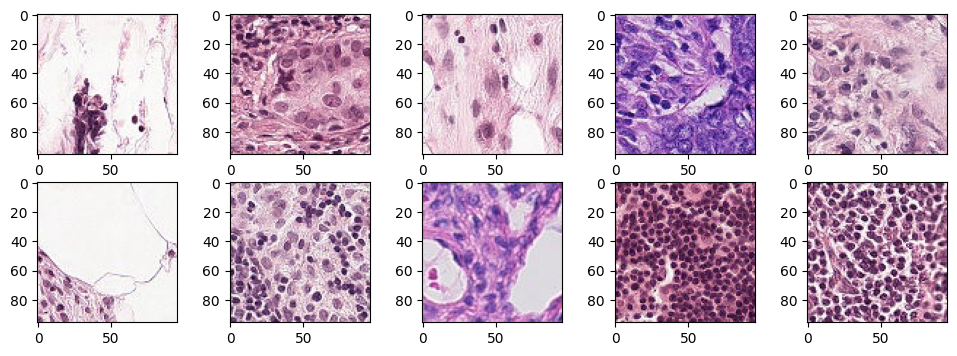

In [39]:
# Display images from dataset
train_image_dir = "/content/train/"

fig, axes = plt.subplots(2, 5, figsize=(12,4))

for i in range(axes.shape[1]):
    positive_row = positive_images.iloc[i]
    negative_row = negative_images.iloc[i]
    positive_image_id = positive_row['id']
    negative_image_id = negative_row['id']

    positive_image_path = os.path.join(train_image_dir, f'{positive_image_id}.tif')
    negative_image_path = os.path.join(train_image_dir, f'{negative_image_id}.tif')

    positive_image = Image.open(positive_image_path)
    negative_image = Image.open(negative_image_path)

    axes[0, i].imshow(positive_image)
    axes[1, i].imshow(negative_image)

plt.show()

## Data Preparation and Cleaning

We'll split the data into train and validation sets.

In [15]:
# Define train and validation datasets
train_df, valid_df = train_test_split(
    train_valid_df,
    test_size=0.2,
    random_state=51,
    stratify=train_valid_df['label'])

In [32]:
len(train_df)

176020

In [33]:
len(valid_df)

44005

In [16]:
# Add the '.tif' file extension to the id column
train_df['id'] = train_df['id'] + '.tif'
valid_df['id'] = valid_df['id'] + '.tif'

train_df.head()

,id,label
205916,a4b3d6162b6f76eed8b88c19108e1946c4b555f5.tif,1
25045,1d73d9659a4d86dc5e128505c5448d3ba8f03823.tif,1
66188,bd1fa8ade3f1c699c32fe5c8781f2490cc80022e.tif,0
215120,83a73e60a062b58262e565d7fd4651f5d8bb3703.tif,0
209499,b25ef695aa6a7a6064985f774e4c8d9dae76858d.tif,0


We'll use the ImageDataGenerator object from keras to enhance the training set images by adding horizontal and vertical flips as well as rescaling pixel intensity to between 0 and 1. The image reflections will give the model greater flexibility in picking out tumors in various orientations and surroundings. These keras objects will also automatically organize the training set into random batches of 256 images for each epoch. This will help to prevent the model from memorizing the data, making the model able to generalize better to unseen images.

For the validation set, we'll scale the intensity of the pixels, but we won't apply the reflection transforms or the batch randomization since we want the validation set to stand as a repeatable frame of reference from batch to batch throughout the training.

In [40]:
# Keras needs the 'label' column to be a string
train_df['label'] = train_df['label'].astype(str)
valid_df['label'] = valid_df['label'].astype(str)

# Define training data generator
train_datagenerator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    vertical_flip=True
)

# Define validation data generator
valid_datagenerator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

# Create the generator objects
BATCH_SIZE = 256

train_generator = train_datagenerator.flow_from_dataframe(
    dataframe=train_df,
    directory='/content/train/',
    x_col='id',
    y_col='label',
    class_mode='categorical',
    target_size=(96, 96),
    batch_size=BATCH_SIZE,
    seed=42,
    filename_ext='.tif'
)

valid_generator = valid_datagenerator.flow_from_dataframe(
    dataframe=valid_df,
    directory='/content/train/',
    x_col='id',
    y_col='label',
    class_mode='categorical',
    target_size=(96, 96),
    batch_size=BATCH_SIZE,
    seed=42,
    shuffle=False,
    filename_ext='.tif'
)

Found 176020 validated image filenames belonging to 2 classes.
Found 44005 validated image filenames belonging to 2 classes.


## Model Architecture

This being an image classification task, I used keras to build a CNN with three convolutional blocks followed by a dense classification layer. The inputs to the first convolution block are a 96x96x3 tensor (3 channels for RGB). The first convolutional block processes the input tensor with 3X3 convolutional kernels (filters) that are 16 channels deep. With `padding='same`, a 1-pixel border is added to the original image to make the ReLU-activated output feature map the same dimensions as the input (96x96). There is a batch normalization layer after this for each filter channel (with two learnable parameters each), which helps to regularize the activations as they are sent to the next layer. Then, last in the first block, there is a max pooling layer with a 2x2 kernel with a stride of 2, which decreases the dimensions of the output feature map by 2. So the final feature map output after the first block is 48x48x16. The 48x48x16 feature map tensor is sent to the second block, where it is processed by 32 3x3x16 filters, outputting a 48x48x32 feature map. This goes through the same batch normalization and pooling, resulting in a 24x24x32 feature map. Then this 24X24x32 is sent to the third block, which after applying equivalent filtering, normalizing, and pooling, yields a 12x12x64 feature map. Then the 12x12x64 tensor is flattened into a 9216-long vector and sent as the input to a densely-connected MLP with 512 neurons in the hidden layer feeding to a two-neuron output layer for classification (a .5 dropout rate is applied at every minibatch in training to prevent overfitting). Softmax is ued to produce probabilities for the image having or not having a tumor.

In [41]:
# Define the CNN model architecture
model_1 = models.Sequential([
    # Define input layer
    tf.keras.Input(shape=(96, 96, 3)),

    # First Convolutional Block
    layers.Conv2D(16, (3, 3), activation='relu', padding='same', name='conv2d_1_conv'),
    layers.BatchNormalization(name='conv2d_1_bn'),
    layers.MaxPooling2D((2, 2), name='conv2d_1_mp'),

    # Second Convolutional Block
    layers.Conv2D(32, (3, 3), activation='relu', padding='same', name='conv2d_2_conv'),
    layers.BatchNormalization(name='conv2d_2_bn'),
    layers.MaxPooling2D((2, 2), name='conv2d_2_mp'),

    # Third Convolutional Block
    layers.Conv2D(64, (3, 3), activation='relu', padding='same', name='conv2d_3_conv'),
    layers.BatchNormalization(name='conv2d_3_bn'),
    layers.MaxPooling2D((2, 2), name='conv2d_3_mp'),

    # Classifier
    layers.Flatten(name='flatten_1'),
    layers.Dense(512, activation='relu', name='dense_1'),
    layers.Dropout(0.5, name='dropout_1'),
    layers.Dense(2, activation='softmax', name='dense_2')
])

model_1.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_1_conv (Conv2D)          │ (None, 96, 96, 16)     │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1_bn                     │ (None, 96, 96, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1_mp (MaxPooling2D)      │ (None, 48, 48, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2_conv (Conv2D)          │ (None, 48, 48, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2_bn                     │ (None, 48, 48, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2_mp (MaxPooling2D)      │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3_conv (Conv2D)          │ (None, 24, 24, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3_bn                     │ (None, 24, 24, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3_mp (MaxPooling2D)      │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │     4,719,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │         1,026 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,744,162 (18.10 MB)

 Trainable params: 4,743,938 (18.10 MB)

 Non-trainable params: 224 (896.00 B)

## Model Training

I trained three different models to explore the effect of hyperparameters like learning rate and the number of training epochs. Additionally, the third model utilized `ReduceLROnPlateau` and `ModelCheckpoint` callbacks to further improve performance.

### Model 1

In [ ]:
model_1.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
EPOCHS_1 = 10

# Train the model
history_1 = model_1.fit(
    train_generator,
    epochs=EPOCHS_1,
    validation_data=valid_generator
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
688/688 ━━━━━━━━━━━━━━━━━━━━ 161s 217ms/step - accuracy: 0.7819 - loss: 0.9738 - val_accuracy: 0.6230 - val_loss: 1.6560
Epoch 2/10
688/688 ━━━━━━━━━━━━━━━━━━━━ 136s 198ms/step - accuracy: 0.8586 - loss: 0.3437 - val_accuracy: 0.7886 - val_loss: 0.5915
Epoch 3/10
688/688 ━━━━━━━━━━━━━━━━━━━━ 135s 197ms/step - accuracy: 0.8814 - loss: 0.2975 - val_accuracy: 0.8820 - val_loss: 0.2932
Epoch 4/10
688/688 ━━━━━━━━━━━━━━━━━━━━ 136s 197ms/step - accuracy: 0.9010 - loss: 0.2565 - val_accuracy: 0.8053 - val_loss: 0.4803
Epoch 5/10
688/688 ━━━━━━━━━━━━━━━━━━━━ 135s 196ms/step - accuracy: 0.9096 - loss: 0.2357 - val_accuracy: 0.8384 - val_loss: 0.5610
Epoch 6/10
688/688 ━━━━━━━━━━━━━━━━━━━━ 134s 195ms/step - accuracy: 0.9154 - loss: 0.2235 - val_accuracy: 0.7626 - val_loss: 0.9943
Epoch 7/10
688/688 ━━━━━━━━━━━━━━━━━━━━ 135s 197ms/step - accuracy: 0.9214 - loss: 0.2101 - val_accuracy: 0.6971 - val_loss: 3.1763
Epoch 8/10
688/688 ━━━━━━━━━━━━━━━━━━━━ 135s 197ms/step - accuracy: 0.9251 -

In [ ]:
print(history_1.history.keys())

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


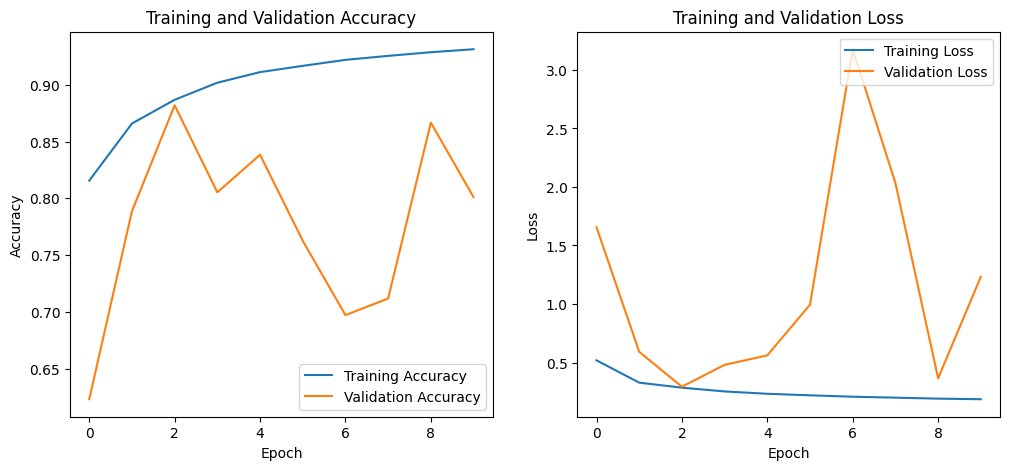

In [ ]:
# Get the metrics from the history object
acc_1 = history_1.history['accuracy']
val_acc_1 = history_1.history['val_accuracy']
loss_1 = history_1.history['loss']
val_loss_1 = history_1.history['val_loss']

epochs_range = range(EPOCHS_1)

plt.figure(figsize=(12, 5))

# Plot 1: Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc_1, label='Training Accuracy')
plt.plot(epochs_range, val_acc_1, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

# Plot 2: Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss_1, label='Training Loss')
plt.plot(epochs_range, val_loss_1, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.show()

### Model 1 Results
With the default Adam optimizer learning rate of 0.001, despite the relatively smooth training accuracy and loss curves, the jaggedness in the validation accuracy and loss curves suggests that the learning rate is too high. This high learning rate causes the model's performance on the validation set to fluctuate, making it unable to converge to a stable minimum loss. Furthermore, the increasing gap between the training and validation accuracy (and loss) curves over the epochs indicates that the model is starting to overfit the training data, as it performs much better on the data it has seen compared to the unseen validation data.

### Model 2

In [ ]:
# Define the CNN model architecture
model_2 = models.Sequential([
    # Define input layer
    tf.keras.Input(shape=(96, 96, 3)),

    # First Convolutional Block
    layers.Conv2D(16, (3, 3), activation='relu', padding='same', name='conv2d_1_conv'),
    layers.BatchNormalization(name='conv2d_1_bn'),
    layers.MaxPooling2D((2, 2), name='conv2d_1_mp'),

    # Second Convolutional Block
    layers.Conv2D(32, (3, 3), activation='relu', padding='same', name='conv2d_2_conv'),
    layers.BatchNormalization(name='conv2d_2_bn'),
    layers.MaxPooling2D((2, 2), name='conv2d_2_mp'),

    # Third Convolutional Block
    layers.Conv2D(64, (3, 3), activation='relu', padding='same', name='conv2d_3_conv'),
    layers.BatchNormalization(name='conv2d_3_bn'),
    layers.MaxPooling2D((2, 2), name='conv2d_3_mp'),

    # Classifier
    layers.Flatten(name='flatten_1'),
    layers.Dense(512, activation='relu', name='dense_1'),
    layers.Dropout(0.5, name='dropout_1'),
    layers.Dense(2, activation='softmax', name='dense_2')
])

model_2.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_1_conv (Conv2D)          │ (None, 96, 96, 16)     │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1_bn                     │ (None, 96, 96, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1_mp (MaxPooling2D)      │ (None, 48, 48, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2_conv (Conv2D)          │ (None, 48, 48, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2_bn                     │ (None, 48, 48, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2_mp (MaxPooling2D)      │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3_conv (Conv2D)          │ (None, 24, 24, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3_bn                     │ (None, 24, 24, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3_mp (MaxPooling2D)      │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │     4,719,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │         1,026 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,744,162 (18.10 MB)

 Trainable params: 4,743,938 (18.10 MB)

 Non-trainable params: 224 (896.00 B)

In [ ]:
# Set a lower learning rate
optimizer = Adam(learning_rate=0.0001)

model_2.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
EPOCHS_2 = 10

history_2 = model_2.fit(
    train_generator,
    epochs=EPOCHS_2,
    validation_data=valid_generator
)

Epoch 1/10
688/688 ━━━━━━━━━━━━━━━━━━━━ 150s 209ms/step - accuracy: 0.7803 - loss: 0.5569 - val_accuracy: 0.8288 - val_loss: 0.3957
Epoch 2/10
688/688 ━━━━━━━━━━━━━━━━━━━━ 138s 200ms/step - accuracy: 0.8402 - loss: 0.3664 - val_accuracy: 0.8542 - val_loss: 0.3401
Epoch 3/10
688/688 ━━━━━━━━━━━━━━━━━━━━ 136s 197ms/step - accuracy: 0.8582 - loss: 0.3312 - val_accuracy: 0.8495 - val_loss: 0.3425
Epoch 4/10
688/688 ━━━━━━━━━━━━━━━━━━━━ 138s 200ms/step - accuracy: 0.8685 - loss: 0.3138 - val_accuracy: 0.8785 - val_loss: 0.2929
Epoch 5/10
688/688 ━━━━━━━━━━━━━━━━━━━━ 138s 201ms/step - accuracy: 0.8761 - loss: 0.2991 - val_accuracy: 0.8816 - val_loss: 0.2844
Epoch 6/10
688/688 ━━━━━━━━━━━━━━━━━━━━ 135s 197ms/step - accuracy: 0.8835 - loss: 0.2813 - val_accuracy: 0.8855 - val_loss: 0.2821
Epoch 7/10
688/688 ━━━━━━━━━━━━━━━━━━━━ 136s 197ms/step - accuracy: 0.8915 - loss: 0.2670 - val_accuracy: 0.8756 - val_loss: 0.2970
Epoch 8/10
688/688 ━━━━━━━━━━━━━━━━━━━━ 136s 197ms/step - accuracy: 0.8958 -

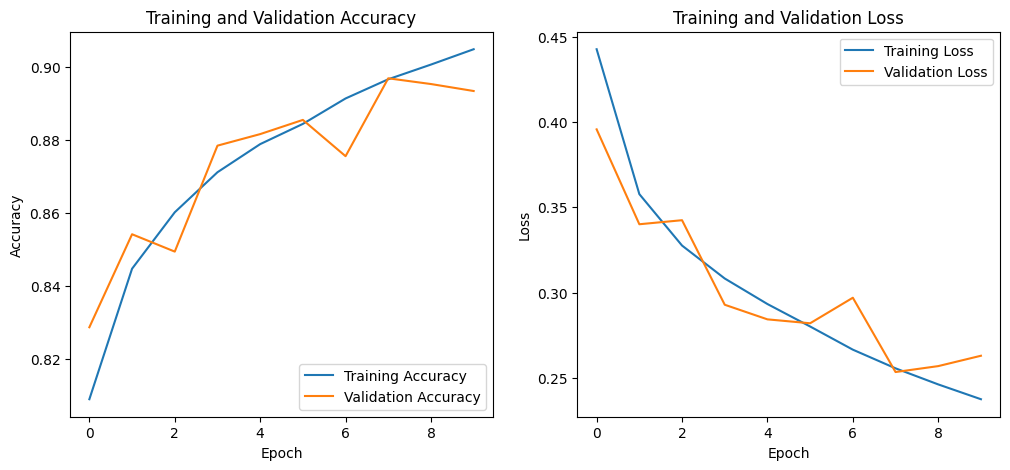

In [ ]:
# Get the metrics from the history object
acc_2 = history_2.history['accuracy']
val_acc_2 = history_2.history['val_accuracy']
loss_2 = history_2.history['loss']
val_loss_2 = history_2.history['val_loss']

epochs_range = range(EPOCHS_2)

plt.figure(figsize=(12, 5))

# Plot 1: Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc_2, label='Training Accuracy')
plt.plot(epochs_range, val_acc_2, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

# Plot 2: Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss_2, label='Training Loss')
plt.plot(epochs_range, val_loss_2, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.show()

### Model 2 Results

In Model 2, reducing the Adam optimizer training rate to 0.0001 dramatically cuts down on the erratic oscillations of the validation curve. Even though the training curve accuracy is slightly lower and the training loss slightly higher than Model 1, more importantly, the validation accuracy is higher and the validation loss lower than Model 1. This suggests that the lower learning rate helped the model generalize better. While the training curves do show progress toward a "plateau", the learning rate might be slightly too high to reach the final point of convergence, or the model could benefit from additional training epochs to give the optimizer more time to reach the minimum. These possibilities will be explored in Model 3.

### Model 3

In [18]:
tf.config.run_functions_eagerly(True)

In [19]:
# Define the CNN model architecture
model_3 = models.Sequential([
    # Define input layer
    tf.keras.Input(shape=(96, 96, 3)),

    # First Convolutional Block
    layers.Conv2D(16, (3, 3), activation='relu', padding='same', name='conv2d_1_conv'),
    layers.BatchNormalization(name='conv2d_1_bn'),
    layers.MaxPooling2D((2, 2), name='conv2d_1_mp'),

    # Second Convolutional Block
    layers.Conv2D(32, (3, 3), activation='relu', padding='same', name='conv2d_2_conv'),
    layers.BatchNormalization(name='conv2d_2_bn'),
    layers.MaxPooling2D((2, 2), name='conv2d_2_mp'),

    # Third Convolutional Block
    layers.Conv2D(64, (3, 3), activation='relu', padding='same', name='conv2d_3_conv'),
    layers.BatchNormalization(name='conv2d_3_bn'),
    layers.MaxPooling2D((2, 2), name='conv2d_3_mp'),

    # Classifier
    layers.Flatten(name='flatten_1'),
    layers.Dense(512, activation='relu', name='dense_1'),
    layers.Dropout(0.5, name='dropout_1'),
    layers.Dense(2, activation='softmax', name='dense_2')
])

model_3.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_1_conv (Conv2D)          │ (None, 96, 96, 16)     │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1_bn                     │ (None, 96, 96, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1_mp (MaxPooling2D)      │ (None, 48, 48, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2_conv (Conv2D)          │ (None, 48, 48, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2_bn                     │ (None, 48, 48, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2_mp (MaxPooling2D)      │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3_conv (Conv2D)          │ (None, 24, 24, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3_bn                     │ (None, 24, 24, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3_mp (MaxPooling2D)      │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │     4,719,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │         1,026 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,744,162 (18.10 MB)

 Trainable params: 4,743,938 (18.10 MB)

 Non-trainable params: 224 (896.00 B)

In [20]:
# Reduce the learning rate when validation loss plateaus
lr_scheduler = ReduceLROnPlateau(monitor='val_loss',
                                 patience=2,
                                 factor=0.2,
                                 min_lr=0.00001)

In [21]:
# Save the best model based on validation loss
model_checkpoint = ModelCheckpoint(filepath='best_model.keras',
                                   save_best_only=True,
                                   monitor='val_loss',
                                   mode='min')

In [22]:
optimizer_3 = Adam(learning_rate=0.0001)

model_3.compile(optimizer=optimizer_3,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [23]:
EPOCHS_3 = 20

history_3 = model_3.fit(
    train_generator,
    epochs=EPOCHS_3,
    validation_data=valid_generator,
    callbacks=[lr_scheduler, model_checkpoint]
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20


/usr/local/lib/python3.12/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


688/688 ━━━━━━━━━━━━━━━━━━━━ 229s 325ms/step - accuracy: 0.7932 - loss: 0.5157 - val_accuracy: 0.8088 - val_loss: 0.4308 - learning_rate: 1.0000e-04
Epoch 2/20
688/688 ━━━━━━━━━━━━━━━━━━━━ 225s 327ms/step - accuracy: 0.8419 - loss: 0.3615 - val_accuracy: 0.8634 - val_loss: 0.3240 - learning_rate: 1.0000e-04
Epoch 3/20
688/688 ━━━━━━━━━━━━━━━━━━━━ 225s 327ms/step - accuracy: 0.8596 - loss: 0.3297 - val_accuracy: 0.8681 - val_loss: 0.3094 - learning_rate: 1.0000e-04
Epoch 4/20
688/688 ━━━━━━━━━━━━━━━━━━━━ 224s 325ms/step - accuracy: 0.8710 - loss: 0.3099 - val_accuracy: 0.8726 - val_loss: 0.3017 - learning_rate: 1.0000e-04
Epoch 5/20
688/688 ━━━━━━━━━━━━━━━━━━━━ 226s 328ms/step - accuracy: 0.8785 - loss: 0.2924 - val_accuracy: 0.8760 - val_loss: 0.2982 - learning_rate: 1.0000e-04
Epoch 6/20
688/688 ━━━━━━━━━━━━━━━━━━━━ 228s 331ms/step - accuracy: 0.8837 - loss: 0.2788 - val_accuracy: 0.8859 - val_loss: 0.2789 - learning_rate: 1.0000e-04
Epoch 7/20
688/688 ━━━━━━━━━━━━━━━━━━━━ 229s 332ms/

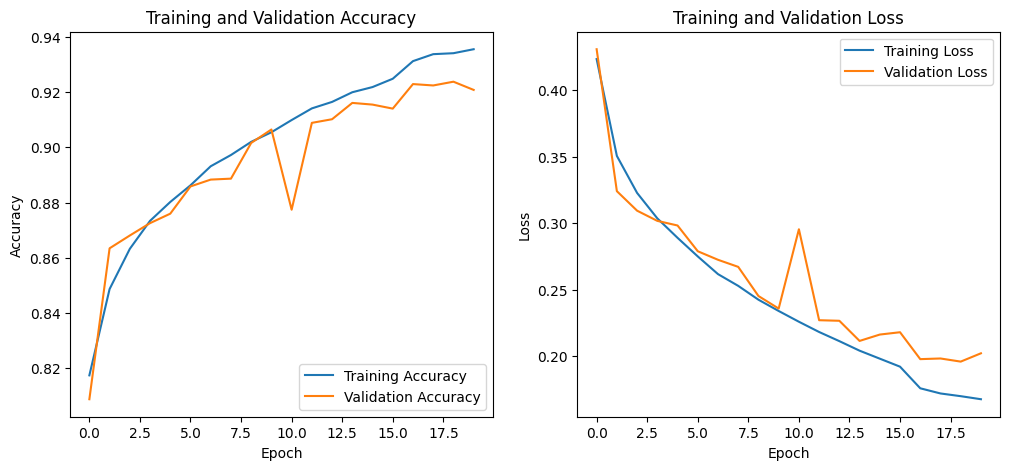

In [24]:
# Get the metrics from the history object
acc_3 = history_3.history['accuracy']
val_acc_3 = history_3.history['val_accuracy']
loss_3 = history_3.history['loss']
val_loss_3 = history_3.history['val_loss']

epochs_range = range(EPOCHS_3)

plt.figure(figsize=(12, 5))

# Plot 1: Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc_3, label='Training Accuracy')
plt.plot(epochs_range, val_acc_3, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

# Plot 2: Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss_3, label='Training Loss')
plt.plot(epochs_range, val_loss_3, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.show()

In [25]:
# Load the saved model
best_model = load_model('best_model.keras')

In [43]:
best_model.evaluate(valid_generator)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
/usr/local/lib/python3.12/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


172/172 ━━━━━━━━━━━━━━━━━━━━ 30s 173ms/step - accuracy: 0.9235 - loss: 0.1955


[0.19590860605239868, 0.9237813949584961]

### Model 3 Results

Model 3 is the best performing of the three in terms of final accuracy and validation curve stability (with the exception of the spike in epoch 10, which potentially could be due to the variability of training on randomized batches). By increasing the number of epochs from 10 to 20 and adding the `ReduceLROnPlateau` to dynamically reduce the learning rate and `ModelCheckpoint` to return the best validation scores, Model 3 performance significantly improved. The final "best model" interestingly was not the one produced at the final epoch. Looking at the curves, it's clear that the validation curve starts to diverge slightly from the training curve in the 19th epoch, indicating that the model is beginning to overfit past that point.

In [29]:
# Set up test data frame
test_dir = '/content/test'

test_filenames = os.listdir(test_dir)

test_df = pd.DataFrame({'id': test_filenames})

# Define test data generator object
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory=test_dir,
    x_col='id',
    y_col=None,
    class_mode=None,
    target_size=(96, 96),
    batch_size=BATCH_SIZE,
    shuffle=False
)

Found 57458 validated image filenames.


In [30]:
# Get the model's predictions
predictions = best_model.predict(test_generator)

# Get the class (0 or 1) with the highest probability for each prediction
predicted_labels = np.argmax(predictions, axis=1)

225/225 ━━━━━━━━━━━━━━━━━━━━ 37s 162ms/step


In [31]:
# Get the test image IDs (without the '.tif' extension)
test_ids = [name.split('.')[0] for name in test_generator.filenames]

# Create the submission DataFrame
submission_df = pd.DataFrame({
    'id': test_ids,
    'label': predicted_labels
})

submission_df.to_csv('submission.csv', index=False)

submission_df.head()

,id,label
0,82fdeb187d92846d3b59cf863a6124f86ed17c62,1
1,68e43f8bb342ba82d0c8317868efe370a269eec7,1
2,2e4031048d1981f4bed88b9fc2aa470006c61c32,0
3,6f961a87ee81e7777da89f245881897dab414f09,0
4,644ac391bf5b2b8847e9d256ae5e690a9704ef94,1


## Conclusion

In this notebook, I explored building a CNN for identifying tumors in the Histopathologic Cancer Detection image dataset from Kaggle. With access to a GPU (Nvidia A100), I wanted to see if I could build a model from scratch using the entire training set that would exhibit reasonbly "good" performance, as measured against the Kaggle test dataset.

This model is not comparable in scale to the much larger CNNs of today with hundreds of layers and potentially hundreds of millions (or billions) of parameters. Yet, this model received a public score of 0.8478 and a private score of 0.7954, which I think is decent for a first try. I would be interested to see how this performance compares to similar architectures, as well as how this would compare to different model architectures such as those with a pre-trained convlutional network like ResNet. Optimizing the model further through architectural modifications or adding purpose-built networks is a logical next step.